# 分析OSM中上海的数据—— Data Wrangling with SQL

### 目录

* [项目综述](#项目综述)
* [文件结构说明](#文件结构说明)
* [数据分析过程](#数据分析过程)
    * [了解文件结构](#1.对文件结构进行了解)
    * [分析数据值](#2.分析element的值)
    * [数据存在问题](#3.数据问题)
    * [数据清理](#4.数据修正)
* [数据库数据准备](#搜集数据库源数据及创建数据库)
* [使用SQL查询](#使用SQL查询数据)
    * [查询结论](#查询报告)
* [参考及建议](#参考和建议)

## 项目综述 
数据选取的Open Street Map的区域为中国上海的数据，基于项目要求分析数据的Raw data要求在50M以上；另一方面，上海([Shanghai_china.osm](https://mapzen.com/data/metro-extracts/metro/shanghai_china/))地处长江三角洲冲积平原前沿，东临东海北距长江，在国内的经济等方面占有重要的地位。同时上海的交通道路发达，分析OSM中上海的道路数据具有典型的意义——可以反应国内城市道路数据在地图库中的数据情况，包括数据存在的问题，对数据设计有效性、一致性等方面有重要意义。

## 文件结构说明
项目中建立了用于作工具的模块，结果文件夹，样本数据文件下，具体说明如下：
1. createCSV.py——搜集XML文件后，创建CSV文件
2. createDB.py——创建数据库，并将CSV文件导入到数据库
3. createsample.py——根据下载到原始数据源，创建用于分析的样本数据
4. report.html——结果展示文件
5. result——保存结果的文件夹
6. sqlschema.py——用于检验解析后的数据是否符合SQL的schema格式
7. tool.py——编写的用于解析数据的模块文件
8. wrangling.py——用于测试数据清理的文件
9. <font color="red">原始数据在originaldata文件夹中</font>
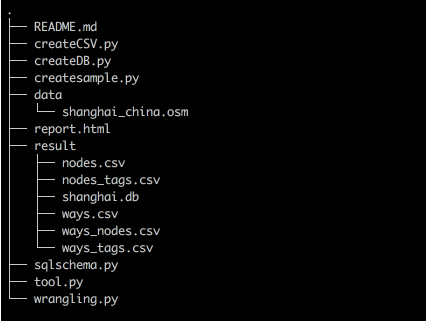

结果说明了，一级element有node、way以及relation；二级element主要是tag，以及relation下有member。各元素对结构及其attribute如下：
```python
{'node': {'changeset',
'id',
'lat',
'lon',
'timestamp',
'uid',
'user',
'version'},
'node_child_tag': {'k', 'v'},
'relation': {'changeset', 'id', 'timestamp', 'uid', 'user', 'version'},
'relation_child_member': {'ref', 'role', 'type'},
'relation_child_tag': {'k', 'v'},
'way': {'changeset', 'id', 'timestamp', 'uid', 'user', 'version'},
'way_child_nd': {'ref'},
'way_child_tag': {'k', 'v'}}
```

In [1]:
import xml.etree.cElementTree as ET
from collections import defaultdict
import re
from sqlschema import schema
import cerberus
import pprint
import tool
import csv

In [2]:
file_name = "data/shanghai_china.osm"

In [3]:
all_tags_dict = tool.get_all_tags(file_name)
# create a dict about the information of the elementary tag after the root
tags_dict = tool.get_tags(file_name)


sub_tags_dict = defaultdict(int)
for i in all_tags_dict.keys():
    if i in ["osm", "bounds"] or i in tags_dict.keys():
        continue
    else:
        sub_tags_dict[i] = all_tags_dict[i]


"""
 Now, I will get the information of the tags' attributes.Next, I want to analysis the
 keys about the tags, which I use two different tags.They are elementary tags,
 and the other one is secondary tags.
"""

with open(file_name, "r") as file:
    elements = ET.iterparse(file, events=("start", "end"))
    parent_attribute = tool.get_attr_dict(elements, tags=tags_dict)

with open(file_name, "r") as file:
    elements = ET.iterparse(file, events=("start", "end"))
    all_subattr_dict = tool.get_attr_dict(elements, tags=sub_tags_dict)

with open(file_name, "r") as file:
    trees = ET.parse(file)
    root = trees.getroot()

    child_attr = dict()

    for element in root:
        if element.tag in parent_attribute:
            for child in element.getchildren():
                child_key = element.tag + "_child_" + child.tag

                for key in child.attrib.keys():
                    if child_key not in child_attr:
                        child_attr[child_key] = set()

                    child_attr[child_key].add(key)

    # push the parent attr to the all structure, then adding the children's attribute
    all_attr_struc = parent_attribute
    for child_key in child_attr:
        all_attr_struc[child_key] = child_attr[child_key]

In [4]:
print("\nThe attribute of the all element and their children is:")
pprint.pprint(all_attr_struc)


The attribute of the all element and their children is:
{'node': {'changeset',
          'id',
          'lat',
          'lon',
          'timestamp',
          'uid',
          'user',
          'version'},
 'node_child_tag': {'k', 'v'},
 'relation': {'id', 'user', 'changeset', 'version', 'timestamp', 'uid'},
 'relation_child_member': {'ref', 'type', 'role'},
 'relation_child_tag': {'k', 'v'},
 'way': {'id', 'user', 'changeset', 'version', 'timestamp', 'uid'},
 'way_child_nd': {'ref'},
 'way_child_tag': {'k', 'v'}}


### 2.分析element的值
   基于对文件中各element的attribute和对文件内容大致回顾，现在需要对各attribute对值进行分析。了解其中数据值的具体分析，选择了具有代表意义的k值对attribute——street_name，postal_code，wikipedia及name_en进行分析——从街道名称、英文名称、邮编以及wiki名称进行分析。主要用到对代码为：
```python
def audit_attribute(element, attribute):
   '''
   Check the value the attribute in the element!

   The attribute value can choose k or v

   The result is boolen value
   '''
   return attribute == element.attrib['k']
```

同时对特定对attribute进行值检查，统计各种数据数量，主要对代码如下：
```python 

def count_attr_type(element, attribute, check_out: 'out function dict'):
   '''
   count the different type of attribute.

   There are three type of regular pattern.The attribute is k or v.

   return the dict
   '''
   # setup the regular pattern
   lower = re.compile(r'^([a-z]|_)*$')
   lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
   problemchars = re.compile(r'[=\\+/&<>;\\''\\?%#$@\\,\\. \\t\\r\\n]')

   if element.tag == 'tag':
       tag = 0
   if lower.search(element.attrib[attribute]):
       check_out['lower'] += 1
       tag = 1
   elif lower_colon.search(element.attrib[attribute]):
       check_out['lower_colon'] += 1
       tag = 1
   elif problemchars.search(element.attrib[attribute]):
       check_out['problemchars'] += 1
       tag = 1

   if tag == 0:
       check_out['other'] += 1
   return check_out
```

In [5]:
# create a set to store the value, which keeps unique,
with open(file_name, "r") as file:
   street_name = defaultdict(set)
   postal_code = defaultdict(set)
   wikipedia = defaultdict(set)
   name_en = defaultdict(set)
   for _,element in ET.iterparse(file, events=("start",)):
       if element.tag == "tag":
           if tool.audit_attribute(element, "addr:street"):
               street_name["addr:street"].add(element.attrib["v"])
           if tool.audit_attribute(element, "addr:postcode"):
               postal_code["addr:postcode"].add(element.attrib["v"])
           if tool.audit_attribute(element, "wikipedia"):
               wikipedia["wikipedia"].add(element.attrib["v"])
       if element.tag in ["way", "node"]:
           for child in element.iter("tag"):
               if tool.audit_attribute(child, "name:en"):
                   name_en["name:en"].add(child.attrib["v"])

In [6]:
print("The head 20 street name is:\n")
pprint.pprint(list(street_name["addr:street"])[:20])

The head 20 street name is:

['人民路',
 '中山北路',
 '梅州路',
 '圆明园路',
 '建国中路',
 '金汇南路',
 'Huaihai West road Wellington garden',
 '威海路',
 '泉口路',
 '开鲁路',
 '董家渡',
 '农谊路1号',
 'Jindu Rd,',
 '阜新路',
 '延吉东路82弄 Lane 82 of East Yanji Road',
 '鹤庆路358弄',
 '东湖路',
 'Fuquan Rd. (N.)',
 '仙霞西路',
 '松汇中路']


In [7]:
print("The postal code is:\n")
pprint.pprint(postal_code)

The postal code is:

defaultdict(<class 'set'>,
            {'addr:postcode': {'200002',
                               '2000080',
                               '200030',
                               '200031',
                               '200032',
                               '200040',
                               '200062',
                               '200092',
                               '200127',
                               '200135',
                               '200231',
                               '200233',
                               '200237',
                               '200240',
                               '200243',
                               '200333',
                               '200335',
                               '200336',
                               '201103',
                               '201203',
                               '201204',
                               '201315',
                               '201620',
        

In [8]:
print("The wikipedia is:\n")
pprint.pprint(wikipedia)

The wikipedia is:

defaultdict(<class 'set'>,
            {'wikipedia': {'en:Chuzhou',
                           'en:Gangzha District',
                           'en:Gusu District',
                           'en:HVDC Three Gorges – Changzhou',
                           'en:Haimen',
                           'en:Jiande',
                           'en:Jurong, Jiangsu',
                           'en:Line 11, Shanghai Metro',
                           'en:Lishui District',
                           'en:Shanghai',
                           'en:TRON Lightcycle Power Run',
                           'en:The Many Adventures of Winnie the Pooh '
                           '(attraction)',
                           'en:Tongxiang',
                           'en:Xinchang County',
                           'en:Xu Wei',
                           'en:Yiwu',
                           'en:Yixing',
                           'en:Yuyao',
                           'en:Zhonglou District',
  

In [9]:
print("The head 20 english name is:\n")
pprint.pprint(list(name_en["name:en"])[0:20])

The head 20 english name is:

['Daxing Street',
 'Wanzitou Xinyu',
 'Yuanlu Sushi',
 'Chemical Plant Entrance',
 'Luochang Road',
 'Lima Expressway',
 'East Shendi Road',
 'Jianghai Avenue Viaduct',
 'Shijie Road',
 'Longdong Ave',
 'Xinhua',
 'Yuqiao Road',
 'Xinyuan Road',
 'Guyan Road',
 'Ancient Shop Good Food',
 'Liziyuan',
 'Jichang Ave Exit',
 'Zhenzhingxin Road',
 'Tanxian Stone Town',
 'Hulin Road']


In [10]:
# just check the attribute k
check_out =  {"lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}
with open(file_name,"r") as file:
    for _, element in ET.iterparse(file):
        if element.tag =="tag":
            tool.count_attr_type(element,"k", check_out)

In [11]:
print("The total of the attribute k in different type:\n")
pprint.pprint(check_out)

The total of the attribute k in different type:

{'lower': 77524, 'lower_colon': 8276, 'other': 163, 'problemchars': 1}


### 3. 数据问题,
从street_name，poscode，wikipedia及name_en的值中，可以了解到该数据集中存在的问题，如下：
* 数据一致性问题 在name_en中体现明显，该值标示了说明是录入英文名称，但数据中还是存在中文名字(杭州酒家)，street_name中同样存在中英文混用的情况
* 数据有效性 在name_en中，存在不同的简写——对于road有Rd.，Rd，Lu等简写，Highway有Hwy.简写，Library有Lib.简写；另外还存在中文拼音
* 从结果可以看出，四个属性中只有postcode相对较好，但是还是表现出数据长度不一致等情况。实际数据正确性检验还需要加强和清理，因为需要看该地点的postcode是否和实际一致——针对这一问题需要相关的postcode数据字典来比对
* 分析attribute中k值，基本上都是符合提出对正则表达式要求。同样存在数据集大小的问题，需要进一步扩大数据集进行检验

### 4.数据修正
本次数据修正主要是针对已经筛选出的英语名称(name:en)，针对已经找到的数据简写问题进行修正。首先建立了一个比对字典，对相应对值进行修正。当然在修正问题过程中，还有其他方面的问题还需要进行进一步逐渐修正。使用的主要代码如下：
```python
def update_vaue(name, mapping=mapping):,
   '''
   Update the invalidate value!,

   Return the validate value,
   ''',
   for key, value in mapping.items():
       pattern = re.compile(key + r'$')
       if pattern.search(name):
           name = name.replace(pattern.search(name).group(), value)
   return name
```

In [12]:
pattern = re.compile(
    r"(\S*\s+\([N|S|E|W]\)|Lib.|Rd|Lu|Rd.|Hwy.)$", re.IGNORECASE)
#     r"(Lib.|Rd|Lu|Rd.|\S[A-Z][a-z]*)$", re.IGNORECASE)
problem_name = []
done_name = []
for name in name_en["name:en"]:
    m = pattern.search(name)
    if m:
        problem_name.append(m.group())
        done_name.append(tool.update_vaue(name, pattern))

In [13]:
print("Before fixing the name:\n")
pprint.pprint(problem_name)

Before fixing the name:

['Rd.',
 'Rd.',
 'Rd.',
 'Rd',
 'Rd',
 'Rd.',
 'Rd. (E)',
 'Rd.',
 'Rd.',
 'Rd',
 'Rd.',
 'rd',
 'Rd.',
 'Hwy.',
 'Hwy.',
 'Rd. (W)',
 'Rd.',
 'rd',
 'Rd.',
 'Rd.',
 'Rd.',
 'Hwy.',
 'Rd.',
 'Rd.',
 'Rd.',
 'Rd.',
 'Rd',
 'Rd.',
 'Rd.',
 'Hwy.',
 'Rd.',
 'Hwy.',
 'Lu',
 'Rd. (N)',
 'Rd',
 'Lib.',
 'Rd. (S)',
 'Rd. (S)',
 'Hwy.',
 'Rd',
 'Rd.',
 'Lu',
 'Rd.',
 'Rd.',
 'Rd.',
 'Rd.',
 'Rd.',
 'Rd.',
 'Hwy.',
 'Rd.',
 'Hwy.',
 'Rd.',
 'Rd.',
 'Rd',
 'Rd',
 'Hwy.',
 'Rd.',
 'Rd',
 'Rd.',
 'Rd.',
 'Rd.',
 'Rd.',
 'Rd.',
 'Rd.',
 'Rd.',
 'Rd.',
 'Rd.',
 'Rd',
 'Hwy.',
 'Rd.',
 'Rd.',
 'Rd.',
 'Rd',
 'Hwy.',
 'Hwy.',
 'Rd. (S)',
 'Rd.',
 'Rd.',
 'Rd.',
 'Rd. (E)',
 'Rd. (N)',
 'lu',
 'Rd.',
 'Rd',
 'Rd.',
 'lu',
 'Hwy.',
 'lu',
 'Rd.',
 'Rd.',
 'Rd',
 'Rd.',
 'Rd.',
 'Hwy.',
 'Rd',
 'Rd.',
 'Rd. (S)',
 'Rd. (S)',
 'Rd.',
 'Rd.',
 'Rd.',
 'Rd.',
 'Rd.',
 'Rd.',
 'Rd.',
 'Rd',
 'Rd.',
 'Rd.',
 'Rd.',
 'Rd.',
 'Rd.',
 'Rd.']


In [14]:
print("After fixing the name:\n")
pprint.pprint(done_name)

After fixing the name:

['Guangyan Road',
 'Gongji Road',
 'Jinyuan No.5 Road',
 'Caobao Road Xingxi Road',
 'N. Huan Cheng Road',
 'Puting Road',
 'Xietu Road East',
 'Baoyang Road',
 'Jintong Road',
 'South Hongmei Road Xinzhu Road',
 'Xiangzhang Road',
 'VanguaRoad',
 'Caohua Road',
 "Bao'an Highway",
 'Chuannanfeng Highway',
 'Jinshajiang Road West',
 'Yangnan Branch Road',
 'Century BoulevaRoad',
 'Jiya Road',
 'Lianqun Road',
 'Donggang Road',
 'Fenghua Highway',
 'Pingyao Road',
 'Beidi Elevated Road',
 'Taopu Road',
 'Chengnan Road',
 'N. Express Ring Road',
 "91 E'shan Road",
 'Longwu Road',
 'Waiqingsong Highway',
 'Hengxie Road',
 'Liuxiang Highway',
 'MengXi Road',
 'Jiasong Road North',
 'Wuqufang Road',
 'South Area of Tongji Library',
 'Moyu Road South',
 'Tuanjie Road South',
 'Hutai Highway',
 'Wang Mei Road',
 'Nanyuan Road',
 'Panlong Road',
 'Jinying Road',
 'Xuesong Road',
 'Zhenghai Road',
 'Caobao Road',
 'Guanhai Road',
 'Hewang Road',
 'Husong Highway',
 'Chunt

## 搜集数据库源数据及创建数据库
针对源数据XML中有node、way和relation三个主要element，此次创建数据库主要针对node和way分别获取相关csv数据集——nodes.csv、nodes_tags.csv、ways.csv、ways_nodes.csv、ways_tags.csv；之后在加载如sql数据库shanghai.db中。使用到到代码如下：
```python
class UnicodeDictWriter(csv.DictWriter, object):
    def writerow(self, row):
        super(UnicodeDictWriter, self).writerow({
            k: (v.encode('utf-8') if isinstance(v, str) else v) for k, v in row.items()
        })

    def writerows(self, rows):
        for row in rows:
            self.writerow(row)
```
<font color="red">获取csv数据集，请直接在命令行使用如下命令运行：</font>
```python
python createCSV_done.py
```

将获得的5个csv文件，利用csv和sqlite3导入写好的schema和数据源，用到的代码如下：
```python
# inital the database and write the schema in the database
initialdb = sqlite3.connect(dbfile)
initialdb.cursor().executescript(dbschema)
initialdb.commit()


for schema, file in zip(schemas, files):
    cursor.execute(schema)
    if file == "nodes.csv":
        with open("result/" + file, "r", encoding="utf-8") as data:
            csvdata = csv.DictReader(data)
            for row in csvdata:
                # print(row.keys())
                id_value = int(row["id"])
                lat_value = float(row["lat"])
                lon_value = float(row["lon"])
                user_value = str(row["user"])
                uid_value = int(row["uid"])
                version_value = str(row["version"])
                changeset_value = int(row["changeset"])
                timestamp_value = str(row["timestamp"])

                cursor.execute('INSERT INTO nodes VALUES (?,?,?,?,?,?,?,?)',
                               (id_value, lat_value, lon_value, user_value,
                                uid_value, version_value, changeset_value, timestamp_value))
```
<font color="red">将数据写入数据库，请直接使用名行命令</font>
```python
python createDB.py
```

## 使用SQL查询数据

本次数据源已经导入数据库，现需要利用SQL语句查询需要查找的数据。
1. 查询各表格的记录数
2. 查询最多的贡献数量的用户名及贡献数量
3. 贡献数量最多对用户，在不同节点类型和不同道路中贡献版本最多的5个数
4. 在道路和节点中，商店和便利设施最多对5个类型和数量

In [15]:
import sqlite3

In [16]:
connection = sqlite3.connect("result/shanghai.db")
cursor = connection.cursor()

In [17]:
tables = ["nodes", "nodestags", "ways", "waysnodes", "waystags"]

for table in tables:
    query = "SELECT COUNT(*) FROM %s;" % table
    print("The entries about the table %s:" % table)
    print(cursor.execute(query).fetchone()[0])

The entries about the table nodes:
261756
The entries about the table nodestags:
19011
The entries about the table ways:
31741
The entries about the table waysnodes:
311458
The entries about the table waystags:
65787


In [18]:
# query the most contributing user
query = """
SELECT wn.user, COUNT(*) as num
FROM (SELECT user FROM nodes
UNION ALL
SELECT user FROM ways) as wn
GROUP BY wn.user
ORDER BY num DESC
LIMIT 1;
"""
print("The most contributing user is:")
print(cursor.execute(query).fetchone())

The most contributing user is:
('Chen Jia', 47339)


In [19]:
# query the most contributing user whether there are different id 
query = """
SELECT user, id 
FROM nodes
WHERE user="Chen Jia";
"""
for i in cursor.execute(query).fetchmany():
    print(i)

('Chen Jia', 28414623)


In [20]:
# query the most contirbuting user who contribute what type about the nodes
query = """
SELECT nodestags.value, COUNT(nodes.version) as num
FROM nodes, nodestags
WHERE nodes.id = nodestags.id
AND nodes.user="Chen Jia"
GROUP BY nodestags.value
ORDER BY num DESC
LIMIT 5;
"""
for i in cursor.execute(query).fetchall():
    print(i)

('tower', 52)
('PGS', 25)
('gate', 17)
('traffic_signals', 9)
('crossing', 7)


In [21]:
# query the most contirbuting user who contribute what type about ways
query = """
SELECT waystags.value, COUNT(ways.version) as num
FROM ways, waystags
WHERE ways.id = waystags.id
AND ways.user="Chen Jia"
GROUP BY waystags.value
ORDER BY num DESC
LIMIT 5;
"""
for i in cursor.execute(query).fetchall():
    print(i)

('yes', 4731)
('residential', 495)
('service', 344)
('tertiary', 325)
('water', 163)


In [22]:
# query the user who have 1 post
query = """
SELECT COUNT(*)
FROM
    (SELECT sq.user, COUNT(*) as num 
    FROM (SELECT user FROM nodes UNION ALL SELECT user FROM ways) as sq
GROUP BY sq.user
HAVING num=1);
"""
print(cursor.execute(query).fetchone())

(393,)


In [23]:
# query the top 5 amentity
query = """
SELECT value, count(*) as num
FROM nodestags
WHERE key="amenity"
GROUP BY value
ORDER BY num DESC
LIMIT 5;
"""
for i in cursor.execute(query).fetchall():
    print(i)

('bicycle_rental', 172)
('restaurant', 85)
('toilets', 41)
('bank', 32)
('cafe', 31)


In [24]:
# query the top 5 amentity
query = """
SELECT value, count(*) as num
FROM nodestags
WHERE key="shop"
GROUP BY value
ORDER BY num DESC
LIMIT 5;
"""
for i in cursor.execute(query).fetchall():
    print(i)

('supermarket', 31)
('convenience', 30)
('bakery', 8)
('clothes', 8)
('greengrocer', 4)


### 查询报告
1. 各表格的记录数，节点数量为261756，道路数量为31741
2. 最多的贡献数量的用户名及贡献数量，该用户为Chen Jia
3. 贡献数量最多对用户，在节点上其主要贡献在住宿、银行等相关信息更新；而在道路中是服务相关信息
4. 在道路和节点中，商店和便利设施最多对5个类型和数量。节点中主要是自行车出租、餐厅数量较多；而道路信息主要在超市和便利店方面

## 参考和建议
本次项目进过数据清洗及建立数据分析流程中，均出现了的问题，问题内容以及使用到的参考如下：
1. 运行样本数据，使用iterparse解析全文件时候报错(ParseError:no element found)，经过搜索是文件的element没有closing tag。对样本文件进行修改加上了closing tag。参考[stackflow关于ParseErro的解答](https://stackoverflow.com/questions/23001757/python-elementtree-no-element-found-exception)
2. collection.defaultdict以及class dict对象没有index方法，因为这两类对象是mapping的方式，所以如果要获取keys的名称需要调用keys方法。
3. 在更新各element的集合时候，报错(TypeError: 'NoneType' object is not iterable)，一个是对set对方法利用不合理，重新参考了[set的方法](https://docs.python.org/2/library/sets.html)
4. 在数据解析过程中因版本差异，而产生的错误python2.0系列中unicode检验变成了str，在python3.0中[参考stackoveflow](https://stackoverflow.com/questions/19877306/nameerror-global-name-unicode-is-not-defined-in-python-3)
5. 在本次运行过程中，中文的名称因为使用encode方法后变为二进制，在进行构建数据库中，储存为二进制文件。参考[相关文档](https://docs.python.org/3/library/codecs.html)后，解释原因是在encode方法会将值变为二进制文件而且以完整的字符串形式保存，取消encode则保存了中文值


关于数据集的一些建议：
1. 建立数据录入标准 优势是能够对数据录入建立统一规范的要求；另一方面，会限制特殊数据的录入，比如需要当地地区特殊的表达时，就可能出现无法录入数据的问题
2. 建立标准的数据集字典 优势在于对于长期的标准值能够随时读取和检验，保障数据获取后能够正确，方便校验；但是在初期建立数据集字典时，需要投入一定的成本。同时如果出现大范围的更新时，同样需要投入大量成本

